## **1. Google Drive**

In [21]:
#from google.colab import drive
#drive.mount('/content/drive')
#cur_dir = "/content/drive/MyDrive/CH2/Notebooks"
#%cd $cur_dir


In [22]:
#%pip install torchview


## **2. Import Libraries**

In [23]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph
from scipy import ndimage
from PIL import Image
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms as tfs


# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path
import shutil
import gc
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import torch.nn.functional as F

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu128
Device: cuda


## **3. Config**

In [24]:
USE_MASKED_PATCHES = False

In [25]:
datasets_path = os.path.join(os.path.pardir, "an2dl2526c2")

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")
test_data_path = os.path.join(datasets_path, "test_data")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path

if USE_MASKED_PATCHES:
  PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","train_patches_masked")
  SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","submission_patches_masked")
else:
  PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","train_patches")
  SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","submission_patches")

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Patches output path: {PATCHES_OUT}")
print(f"Submission patches output path: {SUBMISSION_PATCHES_OUT}")


# Define where your Ground Truth binary masks are stored
# Assuming filenames match: img_001.png -> mask_001.png (or similar)
MASKS_DIR = os.path.join(datasets_path, "preprocessing_results", "train_patches", "masks")

# ImageNet normalization statistics
IMAGENET_MEAN = [float(x) for x in [0.485, 0.456, 0.406]]  # or convert your current values to float
IMAGENET_STD  = [float(x) for x in [0.229, 0.224, 0.225]]



TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks

Dataset path: ../an2dl2526c2
Train data path: ../an2dl2526c2/train_data
Train labels path: ../an2dl2526c2/train_labels.csv
Test data path: ../an2dl2526c2/test_data
Patches output path: ../an2dl2526c2/preprocessing_results/train_patches
Submission patches output path: ../an2dl2526c2/preprocessing_results/submission_patches


## **4. Train/Val Split**

In [26]:
def create_metadata_dataframe(patches_dir, labels_csv_path):
    """
    Creates a DataFrame mapping patch filenames to their Bag IDs and Labels.
    """
    # 1. Load the labels CSV
    # Assuming CSV structure: [image_id, label] or similar
    df_labels = pd.read_csv(labels_csv_path)

    # Standardize column names for easier merging
    # We assume the first column is the ID and the second is the Label
    id_col = df_labels.columns[0]
    label_col = df_labels.columns[1]

    # Ensure IDs in CSV are strings (to match filenames)
    df_labels[id_col] = df_labels[id_col].astype(str)

    # If the CSV IDs contain extensions (e.g., 'img_001.png'), remove them
    # because our parsed Bag IDs won't have them.
    df_labels[id_col] = df_labels[id_col].apply(lambda x: os.path.splitext(x)[0])

    # 2. List all patch files
    patch_files = [f for f in os.listdir(patches_dir) if f.endswith('.png')]

    # 3. Parse filenames to get Bag IDs
    data = []
    print(f"Found {len(patch_files)} patches. Parsing metadata...")

    for filename in patch_files:
        # Expected format from your preprocessing: {base_name}_p{i}.png
        # Example: "img_0015_p12.png" -> Bag ID should be "img_0015"

        # Split from the right on '_p' to separate Bag ID from Patch Index
        # "img_0015_p12.png" -> ["img_0015", "12.png"]
        try:
            bag_id = filename.rsplit('_p', 1)[0]

            data.append({
                'filename': filename,
                'sample_id': bag_id,
                'path': os.path.join(patches_dir, filename)
            })
        except IndexError:
            print(f"Skipping malformed filename: {filename}")

    # Create temporary patches DataFrame
    df_patches = pd.DataFrame(data)

    # 4. Merge patches with labels
    # This assigns the correct Bag Label to every Patch in that Bag
    df = pd.merge(df_patches, df_labels, left_on='sample_id', right_on=id_col, how='inner')

    # 5. Clean up and Rename
    # Keep only required columns
    df = df[['filename', label_col, 'sample_id', 'path']]

    # Rename label column to standard 'label' if it isn't already
    df = df.rename(columns={label_col: 'label'})

    print(f"Successfully created DataFrame with {len(df)} rows.")
    return df

In [27]:
patches_metadata_df = create_metadata_dataframe(PATCHES_OUT, CSV_PATH)

# Verify the result
print("\nFirst 5 rows:")
print(patches_metadata_df.head().drop(columns=['path']))
print("\nPatches per Bag (Distribution):")
print(patches_metadata_df['sample_id'].value_counts().describe())

Found 2788 patches. Parsing metadata...
Successfully created DataFrame with 2788 rows.

First 5 rows:
          filename      label sample_id
0  img_0690_p2.png  Luminal A  img_0690
1  img_0690_p1.png  Luminal A  img_0690
2  img_0690_p0.png  Luminal A  img_0690
3  img_0689_p3.png  Luminal A  img_0689
4  img_0689_p2.png  Luminal A  img_0689

Patches per Bag (Distribution):
count    631.000000
mean       4.418384
std        2.771610
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       23.000000
Name: count, dtype: float64


In [28]:
# Add Label Encoding
print("\n" + "="*50)
print("Label Encoding")
print("="*50)

label_encoder = LabelEncoder()
patches_metadata_df['label_encoded'] = label_encoder.fit_transform(patches_metadata_df['label'])

print(f"\nOriginal Labels: {label_encoder.classes_}")
print(f"Encoded as: {list(range(len(label_encoder.classes_)))}")
print(f"\nLabel Mapping:")
for orig, enc in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {orig} -> {enc}")


Label Encoding

Original Labels: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Encoded as: [0, 1, 2, 3]

Label Mapping:
  HER2(+) -> 0
  Luminal A -> 1
  Luminal B -> 2
  Triple negative -> 3


In [29]:
# Train/Val Split on Original Images (not patches)
print("\n" + "="*50)
print("Train/Val Split on Original Images")
print("="*50)

# Get unique sample IDs
unique_samples = patches_metadata_df['sample_id'].unique()
print(f"\nTotal unique samples (original images): {len(unique_samples)}")

# Split samples into train (80%) and val (20%)
train_samples, val_samples = train_test_split(
    unique_samples,
    test_size=0.2,
    random_state=SEED,
    stratify=patches_metadata_df.drop_duplicates('sample_id').set_index('sample_id').loc[unique_samples, 'label_encoded'].values
)

print(f"Train samples: {len(train_samples)}")
print(f"Val samples: {len(val_samples)}")

# Create train and val DataFrames by filtering patches
df_train = patches_metadata_df[patches_metadata_df['sample_id'].isin(train_samples)].reset_index(drop=True)
df_val = patches_metadata_df[patches_metadata_df['sample_id'].isin(val_samples)].reset_index(drop=True)

print(f"\nTrain patches: {len(df_train)}")
print(f"Val patches: {len(df_val)}")
print(f"\nTrain label distribution:\n{df_train['label'].value_counts()}")
print(f"\nVal label distribution:\n{df_val['label'].value_counts()}")

# Print percentage distribution
print(f"\n" + "="*50)
print("Percentage Distribution")
print("="*50)
print(f"\nTrain label percentage:\n{df_train['label'].value_counts(normalize=True) * 100}")
print(f"\nVal label percentage:\n{df_val['label'].value_counts(normalize=True) * 100}")


Train/Val Split on Original Images

Total unique samples (original images): 631
Train samples: 504
Val samples: 127

Train patches: 2214
Val patches: 574

Train label distribution:
label
Luminal B          763
Luminal A          631
HER2(+)            618
Triple negative    202
Name: count, dtype: int64

Val label distribution:
label
Luminal B          201
HER2(+)            149
Luminal A          139
Triple negative     85
Name: count, dtype: int64

Percentage Distribution

Train label percentage:
label
Luminal B          34.462511
Luminal A          28.500452
HER2(+)            27.913279
Triple negative     9.123758
Name: proportion, dtype: float64

Val label percentage:
label
Luminal B          35.017422
HER2(+)            25.958188
Luminal A          24.216028
Triple negative    14.808362
Name: proportion, dtype: float64


## **5. Transformations & Augmentation**

In [30]:
# Define augmentation for training with enhanced transformations
train_augmentation = transforms.Compose([
    # Geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  # Small rotations to handle orientation variations
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),  # Reduced from 0.2 for more conservative shifts
        scale=None,  # Add scale variation
        shear=10  # Add shear transformation
    ),

    # Color/appearance transformations
    transforms.ColorJitter(
        brightness=0.2,  # Adjust brightness
        contrast=0.2,    # Adjust contrast
        saturation=0.2,  # Adjust saturation
        hue=0.1          # Slight hue variation
    ),
    #transforms.RandomGrayscale(p=0.1),  # Occasionally convert to grayscale to improve robustness

    # Occlusion simulation
    #transforms.RandomErasing(
    #    p=0.3,  # Reduced probability for more balanced augmentation
    #    scale=(0.02, 0.15),  # Reduced max scale
    #    ratio=(0.3, 3.3)  # Aspect ratio range
    #),

    # Optional: Add Gaussian blur for noise robustness
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
])

## **6. Custom Dataset Class**

In [31]:
import torch
import torchvision.transforms.functional as TF
import random
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class TissueDataset(Dataset):
    def __init__(self, df, img_dir=None, masks_dir=None, augmentation=None, normalize_imagenet=True, target_size=(224, 224), label_col='label_encoded'):
        """
        Args:
            df: DataFrame containing metadata.
            img_dir: Root directory for images.
            masks_dir: (Backwards compat) Root directory.
            augmentation: Augmentation pipeline.
            normalize_imagenet: Boolean to apply ImageNet norm.
            target_size: Tuple (H, W).
            label_col: Column name containing the Integer labels.
        """
        self.df = df
        
        # --- Handle Directory Logic ---
        root_dir = img_dir if img_dir is not None else masks_dir
        
        # Look for masks in root/masks/
        if root_dir:
            self.masks_location = os.path.join(root_dir, 'masks')
        else:
            self.masks_location = None

        self.do_augmentation = augmentation is not None 
        self.normalize_imagenet = normalize_imagenet
        self.target_size = target_size
        self.label_col = label_col

        # 1. Standard Normalization
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
        
        # 2. Image-Only Augmentations
        self.color_jitter = transforms.ColorJitter(
            brightness=0.0, contrast=0.2, saturation=0.0, hue=0.1
        )
        
        # 3. Random Erasing
        self.random_erasing = transforms.RandomErasing(
            p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # --- A. Load Image ---
        img_path = row['path']
        image = Image.open(img_path).convert("RGB")
        
        # --- B. Load Mask (Handle Naming Difference) ---
        if self.masks_location:
            # 1. Get image filename (e.g., 'img_1234_p5.png')
            img_filename = os.path.basename(img_path)
            
            # 2. Convert to mask filename (e.g., 'mask_1234_p5.png')
            # This is the critical fix for your naming convention
            mask_filename = img_filename.replace('img_', 'mask_')
            
            mask_path = os.path.join(self.masks_location, mask_filename)
            
            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert("L") 
            else:
                # Debugging tip: Print this if your masks are all black/empty to verify path
                # print(f"Missing mask: {mask_path}") 
                mask = Image.new('L', image.size, 0)
        else:
            mask = Image.new('L', image.size, 0)

        # --- C. Resize ---
        image = TF.resize(image, self.target_size)
        mask = TF.resize(mask, self.target_size, interpolation=transforms.InterpolationMode.NEAREST)

        # --- D. SYNCHRONIZED AUGMENTATION ---
        if self.do_augmentation:
            if random.random() > 0.5: # Flip
                image = TF.hflip(image)
                mask = TF.hflip(mask)

            angle = transforms.RandomRotation.get_params(degrees=[-15, 15]) # Rotate
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

            # Affine
            ret_angle, translations, scale, shear = transforms.RandomAffine.get_params(
                degrees=[0, 0], translate=(0.1, 0.1), scale_ranges=None, shears=[-10, 10], img_size=image.size
            )
            image = TF.affine(image, angle=ret_angle, translate=translations, scale=scale, shear=shear)
            mask = TF.affine(mask, angle=ret_angle, translate=translations, scale=scale, shear=shear)

            image = self.color_jitter(image) # Color Jitter (Image Only)

        # --- E. Convert to Tensor ---
        img_tensor = TF.to_tensor(image)
        mask_tensor = TF.to_tensor(mask)

        ## --- F. Random Erasing (Image Tensor Only) ---
        #if self.do_augmentation:
        #    img_tensor = self.random_erasing(img_tensor)

        # --- G. Final Prep ---
        mask_tensor = (mask_tensor > 0.5).float()
        
        if self.normalize_imagenet:
            img_tensor = self.normalize(img_tensor)

        # --- H. Return Label ---
        label = torch.tensor(row[self.label_col], dtype=torch.long)
        
        return img_tensor, label, mask_tensor

## **7. Data Loaders**

In [32]:
# Instantiate Datasets
train_dataset = TissueDataset(df_train, augmentation=train_augmentation, normalize_imagenet=True, img_dir=PATCHES_OUT   )
val_dataset = TissueDataset(df_val, augmentation=None, normalize_imagenet=True, img_dir=PATCHES_OUT   )

# Batch Size: 32 or 64 is standard for ResNet18/50 on 1MP images
BATCH_SIZE = 64

cpu_cores = os.cpu_count() or 2
num_workers = cpu_cores//2
# Instantiate Loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # Shuffle patches to break batch correlations
    num_workers=num_workers,         # Adjust based on your CPU
    pin_memory=True        # Faster data transfer to CUDA
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # No need to shuffle validation
    num_workers=num_workers,
    pin_memory=True
)

print(f"Train Loader: {len(train_loader)} batches")
print(f"Val Loader: {len(val_loader)} batches")
print(f"Num workers: {train_loader.num_workers}")

Train Loader: 35 batches
Val Loader: 9 batches
Num workers: 24



Visualizing Training Batch (Augmented):


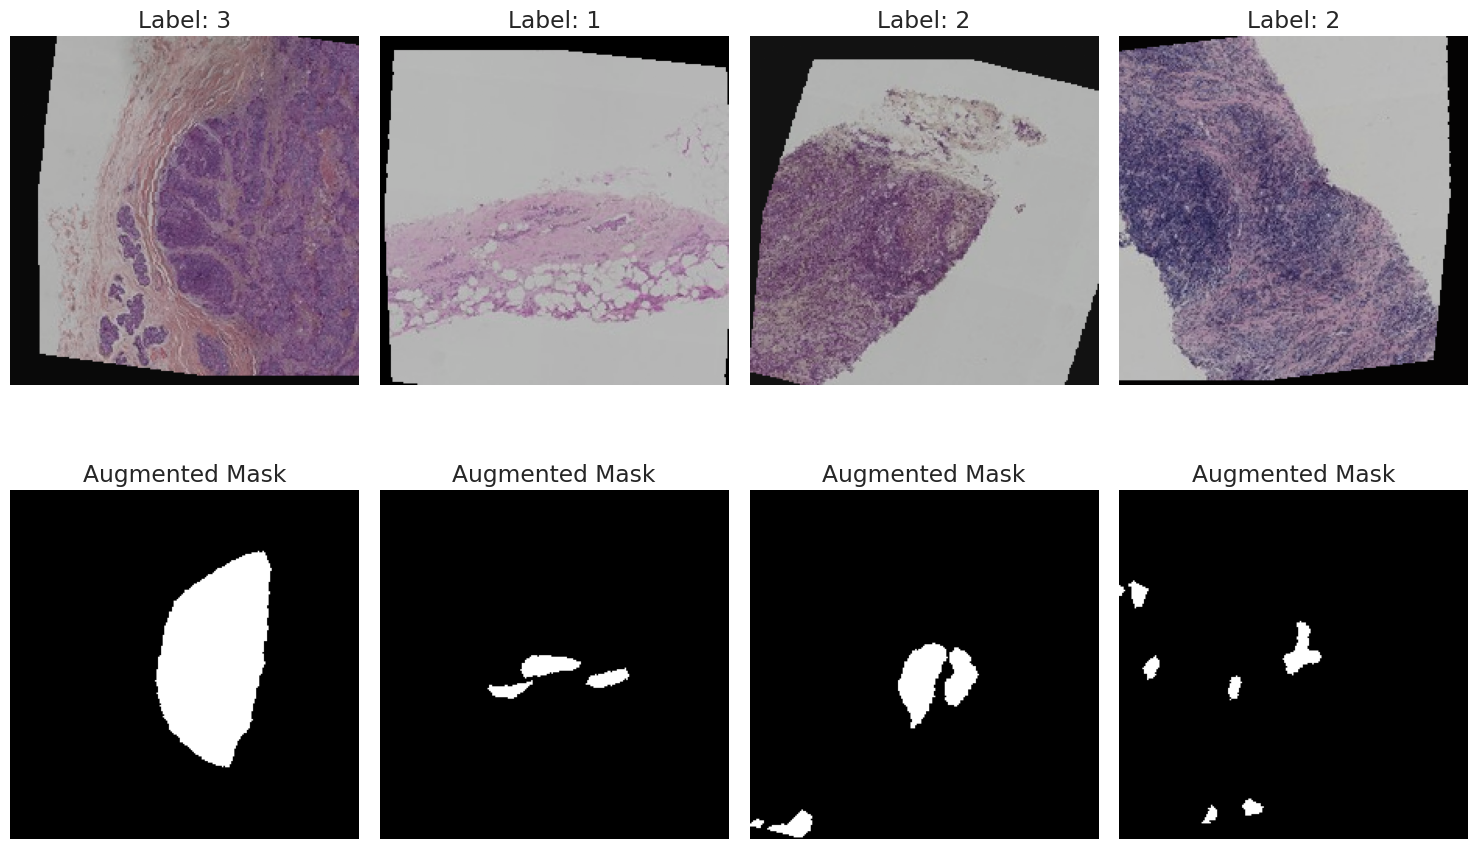

In [33]:
def show_batch(loader, count=4):
    # 1. Robust Unpacking
    # The loader might return 2 items (Image, Label) or 3 (Image, Label, Mask)
    batch = next(iter(loader))
    images, labels = batch[0], batch[1]
    masks = batch[2] if len(batch) > 2 else None

    # Determine layout: 1 row if no masks, 2 rows if masks exist
    nrows = 2 if masks is not None else 1
    plt.figure(figsize=(15, 5 * nrows))

    # Denormalize for visualization (ImageNet stats)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i in range(count):
        # --- Plot Image ---
        ax = plt.subplot(nrows, count, i + 1)
        
        img = images[i]
        img = img * std + mean  # Un-normalize
        img = torch.clamp(img, 0, 1)  # Clip to valid range
        
        plt.imshow(img.permute(1, 2, 0)) # CHW -> HWC
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")

        # --- Plot Mask (if available) ---
        if masks is not None:
            ax = plt.subplot(nrows, count, i + 1 + count) # Second row
            mask = masks[i]
            # Mask is (1, H, W), squeeze to (H, W) for matplotlib
            plt.imshow(mask.squeeze(), cmap="gray")
            plt.title("Augmented Mask")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

print("\nVisualizing Training Batch (Augmented):")
show_batch(train_loader)

## **8. Hyperparameters**

In [34]:
DROPOUT_RATE = 0.3
HIDDEN_SIZE = 512
L2_REG = 1e-4

NUM_EPOCHS_FT = 100
NUM_EPOCHS_TL = 5  # Increased since we have early stopping
PATIENCE = 5    # Stop if val_loss doesn't improve for 5 epochs

# Hyperparameter: How much focus to put on the mask task (0.0 to 1.0)
# 0.3 is a good starting point (30% mask focus, 70% classification focus)
MASK_LOSS_WEIGHT = 0.3

## **9. Model Definition (Transfer Learning - MobileNetV3)**

In [35]:
import torch
import torch.nn as nn
from torchvision import models

import torch
import torch.nn as nn
import torchvision.models as models

class ResNetMTL(nn.Module):
    def __init__(self, num_classes=4, backbone_name='resnet50', freeze_backbone=False):
        super(ResNetMTL, self).__init__()
        
        # 1. Load Backbone
        if backbone_name == 'resnet18':
            base_model = models.resnet18(weights='DEFAULT')
            out_channels = 512
        else:
            base_model = models.resnet50(weights='DEFAULT')
            out_channels = 2048 
            
        # Remove the original FC and Average Pooling layers
        self.backbone = nn.Sequential(*list(base_model.children())[:-2])
        
        # --- FREEZE LOGIC ---
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print(f"Backbone ({backbone_name}) is FROZEN. Only heads will train.")
        else:
            print(f"Backbone ({backbone_name}) is UN-FROZEN. All layers will train.")
        
        # 2. Classification Head
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_channels, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
        
        # 3. Segmentation Head (U-Net style decoder)
        self.seg_head = nn.Sequential(
            # Reduce channels: 2048 -> 256
            nn.Conv2d(out_channels, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # Upsample 1: 7 -> 28
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # Upsample 2: 28 -> 56
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Upsample 3: 56 -> 112
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            
             # Upsample 4: 112 -> 224
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(32, 1, kernel_size=1) 
        )

    def forward(self, x):
        features = self.backbone(x)
        
        # Head 1
        pooled = self.avg_pool(features)
        class_logits = self.classifier(pooled)
        
        # Head 2
        mask_logits = self.seg_head(features)
        
        return class_logits, mask_logits

    def unfreeze_backbone(self):
        """Call this after a few epochs to fine-tune the whole model"""
        for param in self.backbone.parameters():
            param.requires_grad = True
        print("Backbone un-frozen. Ready for fine-tuning.")

In [36]:
# Initialize the model
# Ensure device is defined (usually from previous cells, but safe to redefine if standalone)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming label_encoder is defined in your notebook scope
num_classes = len(label_encoder.classes_)
model = ResNetMTL(num_classes=num_classes,  freeze_backbone=True)
model = model.to(device)

print(f"Model initialized (ResNetMTL) with {num_classes} output classes.")
summary(model, input_size=(3, TARGET_SIZE[0], TARGET_SIZE[1]))


Backbone (resnet50) is FROZEN. Only heads will train.
Model initialized (ResNetMTL) with 4 output classes.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             

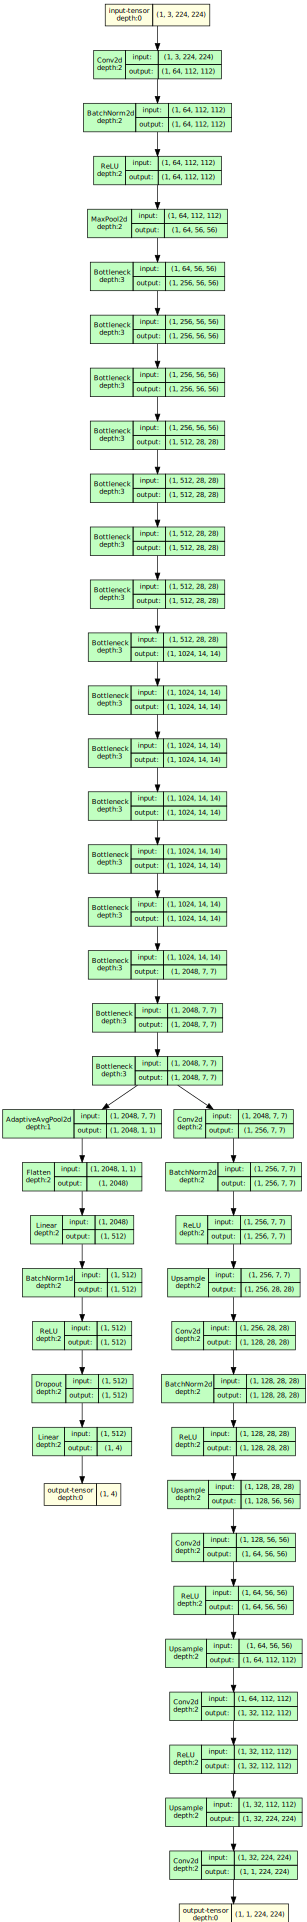

In [37]:
import torchsummary
model_graph = draw_graph(
    model, 
    input_size=(1, 3, TARGET_SIZE[0], TARGET_SIZE[1]), # Added '1' for batch size
    device=device.type
)
model_graph.visual_graph

## **10. Loss and Optimizer**

In [38]:
# 1. Get Counts (from your snippet)
class_counts = df_train['label_encoded'].value_counts().sort_index().values
total_samples = sum(class_counts)
n_classes = len(class_counts)

# 2. Define Manual Tuning Factors (The "weight" knob)
# 1.0 = Default (Pure Inverse Frequency)
# > 1.0 = Force model to focus MORE on this class (e.g., critical error)
# < 1.0 = Force model to focus LESS on this class (e.g., noisy label)
# Ensure this list length matches n_classes (4 in your case)
tuning_factors = torch.tensor([1.0, 1.0, 1.0, 0.6], dtype=torch.float32)

# 3. Calculate Base Weights (Standard Inverse Frequency)
# Formula: N / (C * freq)
base_weights = torch.tensor(
    [total_samples / (n_classes * c) for c in class_counts],
    dtype=torch.float32
)

# 4. Apply Tuning
# Final Weight = Inverse_Freq_Weight * Manual_Tuning_Factor
final_weights = base_weights * tuning_factors

# 5. Move to device
final_weights = final_weights.to(device)

print(f"Base Weights:  {base_weights}")
print(f"Tuning Factors:{tuning_factors}")
print(f"Final Weights: {final_weights}")

# Optimizer
optimizer = torch.optim.RAdam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-3,
    # You can also include other Adam parameters like betas, eps, weight_decay
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=L2_REG
)

# Define TWO losses
criterion_cls = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
criterion_seg = torch.nn.BCEWithLogitsLoss()

Base Weights:  tensor([0.8956, 0.8772, 0.7254, 2.7401])
Tuning Factors:tensor([1.0000, 1.0000, 1.0000, 0.6000])
Final Weights: tensor([0.8956, 0.8772, 0.7254, 1.6441], device='cuda:0')


## **11. Function: Training & Validation Loop**

In [39]:
from sklearn.metrics import f1_score
import numpy as np

def calculate_metrics(preds, targets):
    # Move to CPU and convert to numpy
    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    # Calculate Macro F1 (balanced for all classes)
    return f1_score(targets, preds, average='macro')

In [40]:
def train_one_epoch(model, loader, criterion_cls, criterion_seg, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    # We use tqdm for the progress bar
    loop = tqdm(loader, desc="Training", leave=False)
    
    for images, labels, masks in loop:
        images, labels, masks = images.to(device), labels.to(device), masks.to(device)
        
        optimizer.zero_grad()
        
        # 1. Forward (Dual Heads)
        pred_logits, pred_masks = model(images)
        
        # 2. Combined Loss
        loss_cls = criterion_cls(pred_logits, labels)
        loss_seg = criterion_seg(pred_masks, masks)
        loss = loss_cls + (0.4 * loss_seg) # alpha=0.4
        
        # 3. Backward
        loss.backward()
        optimizer.step()
        
        # 4. Track Statistics
        running_loss += loss.item()
        
        # Get class predictions for F1
        _, predicted = torch.max(pred_logits, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
        
        # Update progress bar
        loop.set_postfix(loss=loss.item())
        
    epoch_loss = running_loss / len(loader)
    epoch_f1 = f1_score(all_targets, all_preds, average='macro')
    
    return epoch_loss, epoch_f1

def validate(model, loader, criterion_cls, criterion_seg, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, labels, masks in loader:
            images, labels, masks = images.to(device), labels.to(device), masks.to(device)
            
            pred_logits, pred_masks = model(images)
            
            loss_cls = criterion_cls(pred_logits, labels)
            loss_seg = criterion_seg(pred_masks, masks)
            loss = loss_cls + (0.4 * loss_seg)
            
            running_loss += loss.item()
            
            _, predicted = torch.max(pred_logits, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            
    epoch_loss = running_loss / len(loader)
    epoch_f1 = f1_score(all_targets, all_preds, average='macro')
    
    return epoch_loss, epoch_f1

## **12. Training Loop: Transfer Learning**

### 12.1 Training

In [41]:

# --- Training Variables ---
best_val_f1 = 0.0
best_val_loss = float('inf')
patience_counter = 0
best_tl_epoch = 0
model_saved = False

history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

print(f"Starting Training with ResNetMTL (Auxiliary Attention) (Patience: {PATIENCE})...")

for epoch in range(NUM_EPOCHS_TL):
    # Train
    train_loss, train_f1 = train_one_epoch(model, train_loader, criterion_cls, criterion_seg, optimizer, device)

    # Validate
    val_loss, val_f1 = validate(model, val_loader, criterion_cls, criterion_seg, device)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    # --- Checkpointing (Save Best Model based on F1) ---
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0  # Reset counter
        best_tl_epoch = epoch + 1
        torch.save(model.state_dict(), 'models/best_model_ResNetMTL_tl.pt')
        model_saved = True
    else:
        model_saved = False
        patience_counter += 1

    # Print matching your requested format
    if model_saved:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS_TL} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter}/{PATIENCE} Best:{best_val_f1:.4f} ✓")
    else:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS_TL} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print("   >>> Early Stopping Triggered! Training stopped.")
        break
    
SUB_MODEL = 'models/best_model_ResNetMTL_tl.pt'
print(f"Submodel saved to {SUB_MODEL} at epoch {best_tl_epoch} with Val F1: {best_val_f1:.4f} for now. Will update if better model found in fine tuning.")

Starting Training with ResNetMTL (Auxiliary Attention) (Patience: 5)...


TL Epoch 1/5 | Loss: 1.7168 | F1: 0.2458 | Val Loss: 1.5100 | Val F1: 0.3254 | Patience: 0/5 Best:0.3254 ✓


TL Epoch 2/5 | Loss: 1.4015 | F1: 0.3477 | Val Loss: 1.4281 | Val F1: 0.3333 | Patience: 0/5 Best:0.3333 ✓


TL Epoch 3/5 | Loss: 1.3220 | F1: 0.4018 | Val Loss: 1.4140 | Val F1: 0.3256 | Patience: 1/5


TL Epoch 4/5 | Loss: 1.2720 | F1: 0.4410 | Val Loss: 1.4270 | Val F1: 0.3488 | Patience: 0/5 Best:0.3488 ✓


TL Epoch 5/5 | Loss: 1.2403 | F1: 0.4804 | Val Loss: 1.4272 | Val F1: 0.3595 | Patience: 0/5 Best:0.3595 ✓
Submodel saved to models/best_model_ResNetMTL_tl.pt at epoch 5 with Val F1: 0.3595 for now. Will update if better model found in fine tuning.


### 12.2 Training History

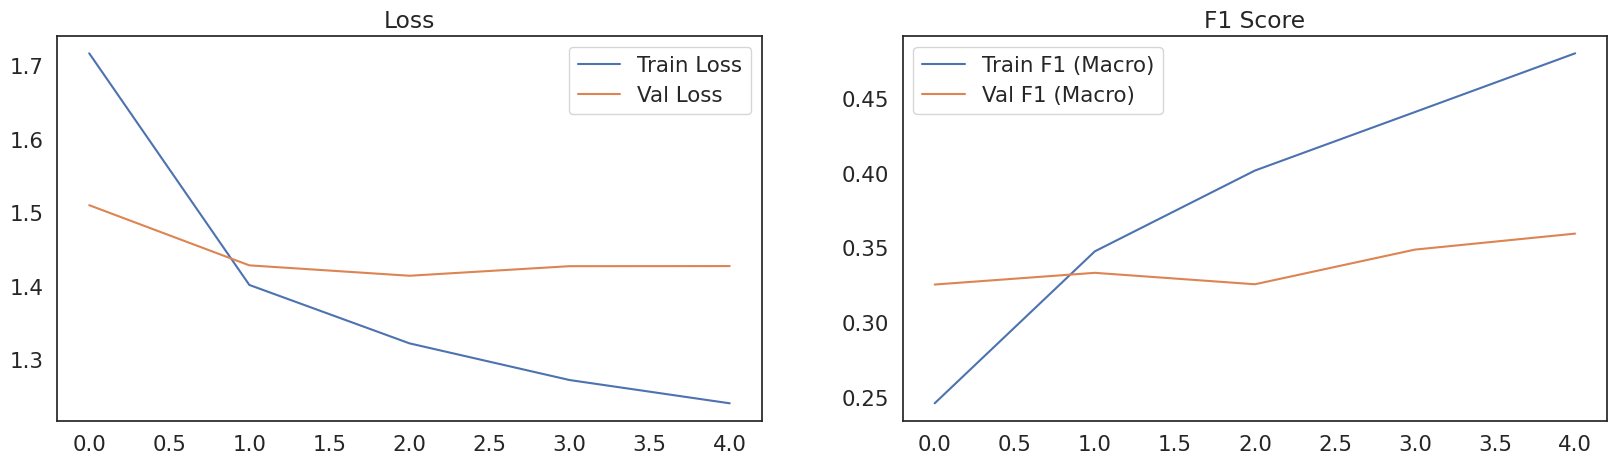

Best Validation F1 Score: 0.3595 at epoch 5


In [42]:
# Plotting results
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_f1'], label='Train F1 (Macro)')
plt.plot(history['val_f1'], label='Val F1 (Macro)')
plt.legend()
plt.title('F1 Score')
plt.show()

print("Best Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1, best_tl_epoch))

### 12.3 Function: Generate Predictions

In [43]:
def get_image_predictions(model, loader, device):
    """
    Aggregates patch-level predictions to image-level.
    Strategy: Average the Softmax probabilities of all patches in a bag.
    """
    model.eval()

    # Access the dataframe from the dataset
    dataset = loader.dataset
    df = dataset.df
    
    # Define the inference transform explicitly to match Validation logic
    # (Resize -> ToTensor -> Normalize)
    inference_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    y_true = []
    y_pred = []

    # Get unique sample IDs (original images)
    sample_ids = df['sample_id'].unique()

    print(f"\nAggregating predictions for {len(sample_ids)} unique images...")

    for sample_id in tqdm(sample_ids, leave=False):
        # Get all patches belonging to this image
        sample_patches = df[df['sample_id'] == sample_id]

        # Ground Truth (all patches share the image label)
        # We use the column name you stored in dataset.label_col (default 'label_encoded')
        true_label = sample_patches.iloc[0]['label_encoded'] 
        y_true.append(true_label)

        # Load and process all patches for this image
        patches = []
        for img_path in sample_patches['path']:
            try:
                # Load image (ensure RGB)
                img = Image.open(img_path).convert('RGB')
                
                # Apply the manual inference transform
                img = inference_transform(img)
                
                patches.append(img)
            except Exception as e:
                continue

        if not patches:
            y_pred.append(true_label) # Fallback
            continue

        # Stack patches into a single batch: [Num_Patches, 3, 224, 224]
        batch = torch.stack(patches).to(device)

        with torch.no_grad():
            # --- CRITICAL CHANGE 1: Unpack the Tuple ---
            # Model returns (class_logits, mask_logits)
            logits, _ = model(batch) 
            
            probs = torch.softmax(logits, dim=1)

            # --- Aggregation: Mean Probability ---
            avg_probs = torch.mean(probs, dim=0)
            pred_label = torch.argmax(avg_probs).item()

        y_pred.append(pred_label)

    return y_true, y_pred

### 12.4 Confusion Matrix

Generating Confusion Matrix on Original Images...

Aggregating predictions for 127 unique images...


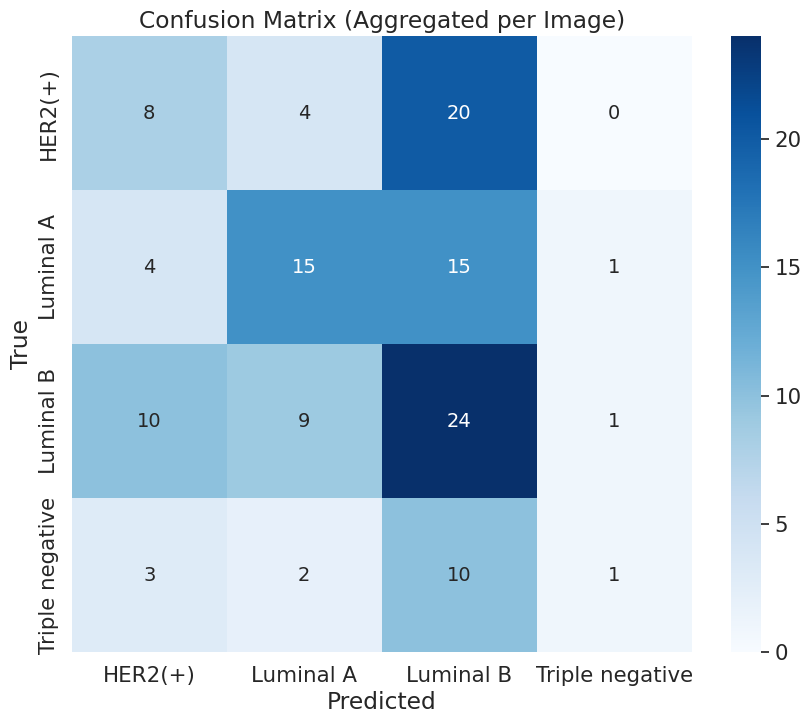

In [47]:

# 3. Calculate and Plot Confusion Matrix
print("Generating Confusion Matrix on Original Images...")
y_true_img, y_pred_img = get_image_predictions(model, val_loader, device)

# Compute Matrix
cm = confusion_matrix(y_true_img, y_pred_img)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Aggregated per Image)')
plt.show()


### 12.5 plot_sample_with_predictions function

In [45]:
import math
def plot_sample_with_predictions(model, loader, device, label_encoder, sample_id=None, aggregation_method='max_confidence'):
    """Plot all patches of a single sample and the aggregated image prediction."""
    model.eval()
    dataset = loader.dataset
    df = dataset.df

    # 1. Pick a sample_id
    if sample_id is None:
        sample_id = np.random.choice(df['sample_id'].unique())
    sample_patches = df[df['sample_id'] == sample_id].reset_index(drop=True)

    # 2. Define Inference Transform (Must match training preprocessing)
    # Since Dataset uses internal functional transforms, we recreate the pipeline here.
    inference_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 3. Load and transform all patches
    images_tensors = []
    display_imgs = []
    
    # Pre-calculated stats for denormalization (Display only)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    for _, row in sample_patches.iterrows():
        try:
            img = Image.open(row['path']).convert('RGB')
            
            # Apply transform for model input
            tensor_img = inference_transform(img)
            images_tensors.append(tensor_img)
            
            # Create display image (Denormalize)
            # We clone to avoid modifying the tensor used for batching
            disp_img = torch.clamp(tensor_img * std + mean, 0, 1)
            display_imgs.append(disp_img)
        except Exception as e:
            print(f"Error loading {row['path']}: {e}")
            continue

    if not images_tensors:
        print("No valid images found for this sample.")
        return

    # 4. Batch Inference
    batch = torch.stack(images_tensors).to(device)
    with torch.no_grad():
        # --- FIX: Unpack tuple (logits, masks) ---
        logits, _ = model(batch) 
        probs = torch.softmax(logits, dim=1).cpu()

    # 5. Process Predictions
    patch_preds = probs.argmax(dim=1).numpy()
    patch_confs = probs.max(dim=1).values.numpy()

    # --- Aggregation Logic (Same as before) ---
    if aggregation_method == 'max_confidence':
        # Soft Voting (Average Probabilities)
        image_probs = probs.mean(dim=0).numpy()
        image_pred = image_probs.argmax()
        image_conf = image_probs[image_pred]
    elif aggregation_method == 'majority_voting':
        # Hard Voting
        counts = np.bincount(patch_preds, minlength=len(label_encoder.classes_))
        image_pred = counts.argmax()
        image_probs = counts / counts.sum()
        image_conf = image_probs[image_pred]
    else:
        raise ValueError(f"Unknown aggregation method: {aggregation_method}")

    # Labels
    image_pred_label = label_encoder.inverse_transform([image_pred])[0]
    # Handle true label lookup safely
    true_label_idx = sample_patches.iloc[0]['label_encoded']
    true_label = label_encoder.inverse_transform([true_label_idx])[0]

    # 6. Plotting
    cols = min(6, len(sample_patches))
    rows = math.ceil(len(sample_patches) / cols)
    
    # Adjust figure size dynamically
    fig = plt.figure(figsize=(3*cols + 4, 3*rows))
    gs = fig.add_gridspec(rows, cols + 1, width_ratios=[1]*cols + [1.3])

    # Patch grid
    for idx, (img_disp, pred, conf) in enumerate(zip(display_imgs, patch_preds, patch_confs)):
        ax = fig.add_subplot(gs[idx // cols, idx % cols])
        ax.imshow(img_disp.permute(1,2,0))
        
        lbl = label_encoder.inverse_transform([pred])[0]
        # Color code title: Green if matches aggregated prediction, else Red
        color = 'green' if pred == image_pred else 'red'
        
        ax.set_title(f"{lbl}\n{conf:.2%}", fontsize=9, color='black', backgroundcolor='white')
        ax.axis('off')

    # Aggregated distribution bar chart
    ax_bar = fig.add_subplot(gs[:, -1])
    class_names = label_encoder.classes_
    colors = ['green' if i == image_pred else 'lightgray' for i in range(len(class_names))]
    
    y_pos = np.arange(len(class_names))
    ax_bar.barh(y_pos, image_probs, color=colors)
    ax_bar.set_yticks(y_pos)
    ax_bar.set_yticklabels(class_names)
    ax_bar.invert_yaxis()  # Labels read top-to-bottom
    
    ax_bar.set_xlabel('Probability' if aggregation_method == 'max_confidence' else 'Vote Share')
    ax_bar.set_xlim([0,1])
    
    # Add title with Sample ID
    ax_bar.set_title(f"Sample: {sample_id}\nTrue: {true_label}\nPred: {image_pred_label} ({image_conf:.2%})\n{aggregation_method}")
    
    # Add value labels
    for i, prob in enumerate(image_probs):
        ax_bar.text(prob + 0.02, i, f"{prob:.3f}", va='center')

    plt.tight_layout()
    plt.show()

### 12.6 Plot samples

Plotting random validation sample with prediction distribution:


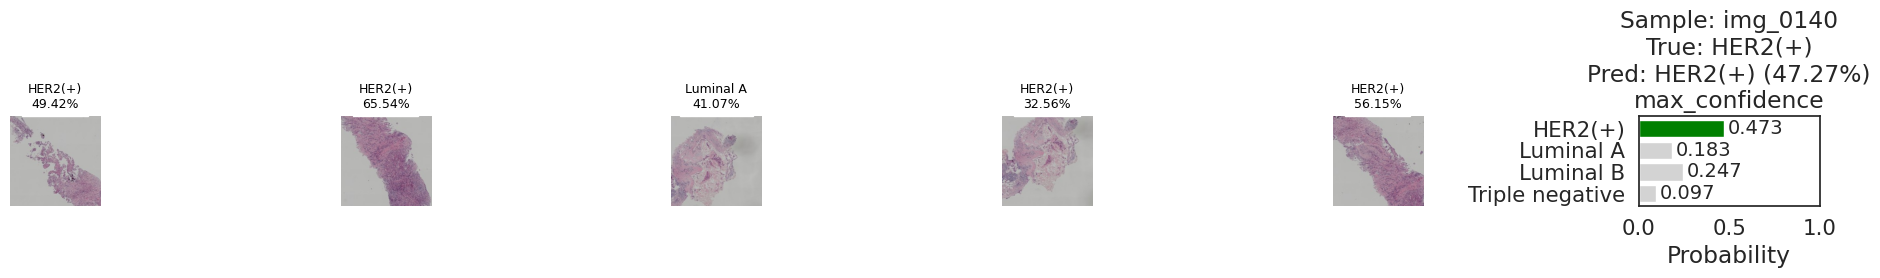

In [46]:
# Visualize a random validation sample
print("Plotting random validation sample with prediction distribution:")
plot_sample_with_predictions(model, val_loader, device, label_encoder, aggregation_method='max_confidence')

## **13. Training Loop: Fine Tuning**

### 13.1 Training

In [50]:
# --- 1. Initialize the NEW model instance ---
# We start with the backbone frozen initially to load weights safely
ft_model = ResNetMTL(num_classes=num_classes,  freeze_backbone=True).to(device)

# --- 2. Load the best weights from the first phase ---
# Note: strict=True ensures our architecture matches exactly
ft_model.load_state_dict(torch.load("models/best_model_ResNetMTL_tl.pt"), strict=True)

# --- 3. Unfreeze parameters for Fine-Tuning ---

# A. Unfreeze the Heads (Classifier & Segmentation)
# In your custom class, these are 'self.classifier' and 'self.aux_head'
for param in ft_model.classifier.parameters():
    param.requires_grad = True
for param in ft_model.seg_head.parameters():
    param.requires_grad = True

# B. Unfreeze the last 2 blocks of the Backbone (Features)
# This allows the model to adapt high-level features to your specific tissue types
# MobileNetV3 features are a Sequential block. We take the last 2 children.
for block in list(ft_model.backbone.children())[-2:]:
    for param in block.parameters():
        param.requires_grad = True

# --- 4. Optimizer ---
# We use RAdam (Rectified Adam) or standard AdamW with a low LR
ft_optimizer = torch.optim.RAdam(
    [p for p in ft_model.parameters() if p.requires_grad],
    lr=1e-5, # Very low learning rate for fine-tuning to prevent destroying features
    weight_decay=1e-4
)

# --- 5. Scheduler ---
ft_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    ft_optimizer, mode='min', factor=0.1, patience=3, 
)

print("Starting Fine-Tuning Phase...")

# Reset history
ft_history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}
best_val_f1_ft = 0.0
patience_counter_ft = 0
best_ft_epoch = 0
model_saved = False
ft_better_than_tl = False

# --- 6. Fine-Tuning Loop ---
for epoch in range(NUM_EPOCHS_FT):
    # Train (Pass BOTH criteria)
    train_loss, train_f1 = train_one_epoch(ft_model, train_loader, criterion_cls, criterion_seg, ft_optimizer, device)

    # Validate (Pass BOTH criteria)
    val_loss, val_f1 = validate(ft_model, val_loader, criterion_cls, criterion_seg, device)

    # Update Scheduler based on Validation Loss
    ft_scheduler.step(val_loss)

    # Store history
    ft_history['train_loss'].append(train_loss)
    ft_history['train_f1'].append(train_f1)
    ft_history['val_loss'].append(val_loss)
    ft_history['val_f1'].append(val_f1)

    # --- Checkpointing & Early Stopping ---
    if val_f1 > best_val_f1_ft:
        best_val_f1_ft = val_f1
        best_ft_epoch = epoch + 1
        patience_counter_ft = 0 
        
        # Save the fine-tuned model
        torch.save(ft_model.state_dict(), 'models/best_model_ResNetMTL_ft.pt')
        model_saved = True
        
        # Check if we beat the Transfer Learning phase
        if best_val_f1_ft > best_val_f1:
            ft_better_than_tl = True
    else:
        model_saved = False
        patience_counter_ft += 1

    # Print Status
    status_mark = "✓" if model_saved else ""
    print(f"FT Epoch {epoch+1}/{NUM_EPOCHS_FT} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter_ft}/{PATIENCE} | LR: {ft_scheduler._last_lr[0]:.6f} {status_mark}")

    if patience_counter_ft >= PATIENCE:
        print(f"\nEarly Stopping Triggered! Best FT Epoch: {best_ft_epoch} with Val F1: {best_val_f1_ft:.4f}")
        break

# Final Summary
final_model_path = 'models/best_model_ResNetMTL_ft.pt' if ft_better_than_tl else 'models/best_model_ResNetMTL_tl.pt'
print(f"\nFine-Tuning Complete.")
print(f"Best TL F1: {best_val_f1:.4f}")
print(f"Best FT F1: {best_val_f1_ft:.4f}")
print(f"Best Model Saved to: {final_model_path}")

Backbone (resnet50) is FROZEN. Only heads will train.
Starting Fine-Tuning Phase...


FT Epoch 1/100 | Loss: 1.1947 | F1: 0.5118 | Val Loss: 1.4231 | Val F1: 0.3538 | Patience: 0/5 ✓


FT Epoch 2/100 | Loss: 1.1971 | F1: 0.5190 | Val Loss: 1.4210 | Val F1: 0.3646 | Patience: 0/5 ✓


FT Epoch 3/100 | Loss: 1.2038 | F1: 0.5134 | Val Loss: 1.4265 | Val F1: 0.3516 | Patience: 1/5 


FT Epoch 4/100 | Loss: 1.1905 | F1: 0.5314 | Val Loss: 1.4203 | Val F1: 0.3586 | Patience: 2/5 


FT Epoch 5/100 | Loss: 1.1935 | F1: 0.5085 | Val Loss: 1.4173 | Val F1: 0.3434 | Patience: 3/5 


FT Epoch 6/100 | Loss: 1.1906 | F1: 0.5231 | Val Loss: 1.4164 | Val F1: 0.3541 | Patience: 4/5 


FT Epoch 7/100 | Loss: 1.1778 | F1: 0.5274 | Val Loss: 1.4150 | Val F1: 0.3539 | Patience: 5/5 

Early Stopping Triggered! Best FT Epoch: 2 with Val F1: 0.3646

Fine-Tuning Complete.
Best TL F1: 0.3595
Best FT F1: 0.3646
Best Model Saved to: models/best_model_ResNetMTL_ft.pt


In [52]:
if ft_better_than_tl:
    print("Fine-Tuning improved over Transfer Learning. Best Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1_ft, best_ft_epoch))
    SUB_MODEL = 'models/best_model_ResNetMTL_ft.pt'
else:
    print("Fine-Tuning did not improve over Transfer Learning. Best Validation F1 Score remains: {:.4f} at epoch {}".format(best_val_f1, best_tl_epoch))
    SUB_MODEL = 'models/best_model_ResNetMTL_tl.pt'

Fine-Tuning improved over Transfer Learning. Best Validation F1 Score: 0.3646 at epoch 2


### 13.2 Training History

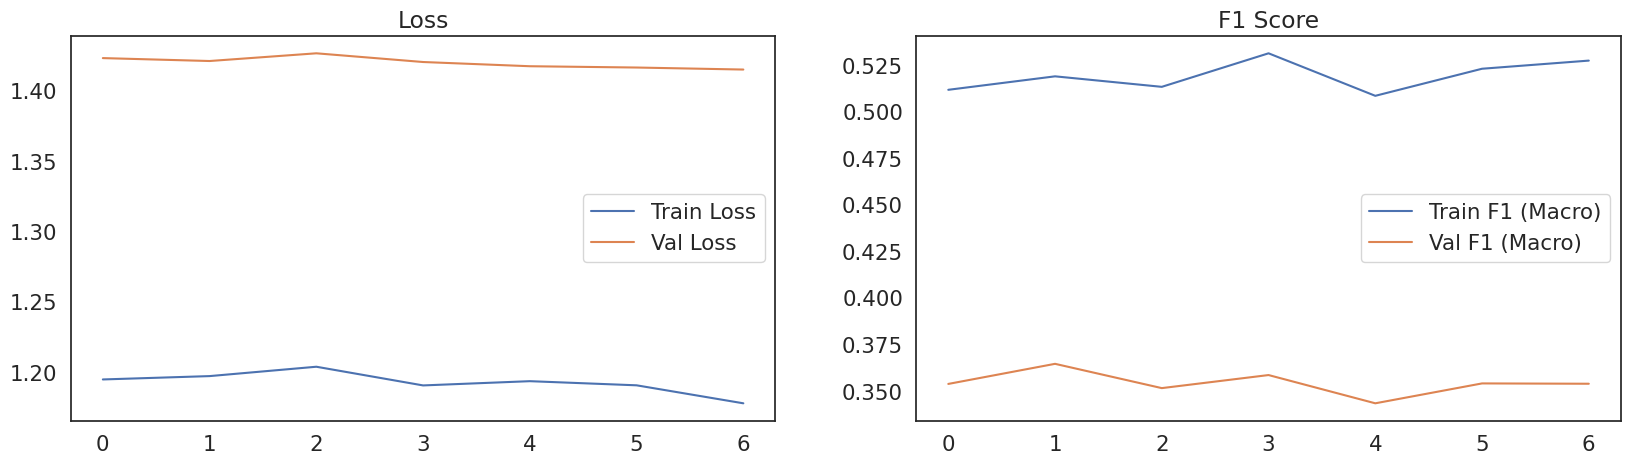

Best Fine-Tuned Validation F1 Score: 0.3595 at epoch 2


In [53]:
# Plotting results
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(ft_history['train_loss'], label='Train Loss')
plt.plot(ft_history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(ft_history['train_f1'], label='Train F1 (Macro)')
plt.plot(ft_history['val_f1'], label='Val F1 (Macro)')
plt.legend()
plt.title('F1 Score')
plt.show()

print("Best Fine-Tuned Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1, best_ft_epoch))

### 13.3 Confusion Matrix

Generating Confusion Matrix for Transfer Learning Model...

Aggregating predictions for 127 unique images...


Generating Confusion Matrix for Fine-Tuning Model...

Aggregating predictions for 127 unique images...


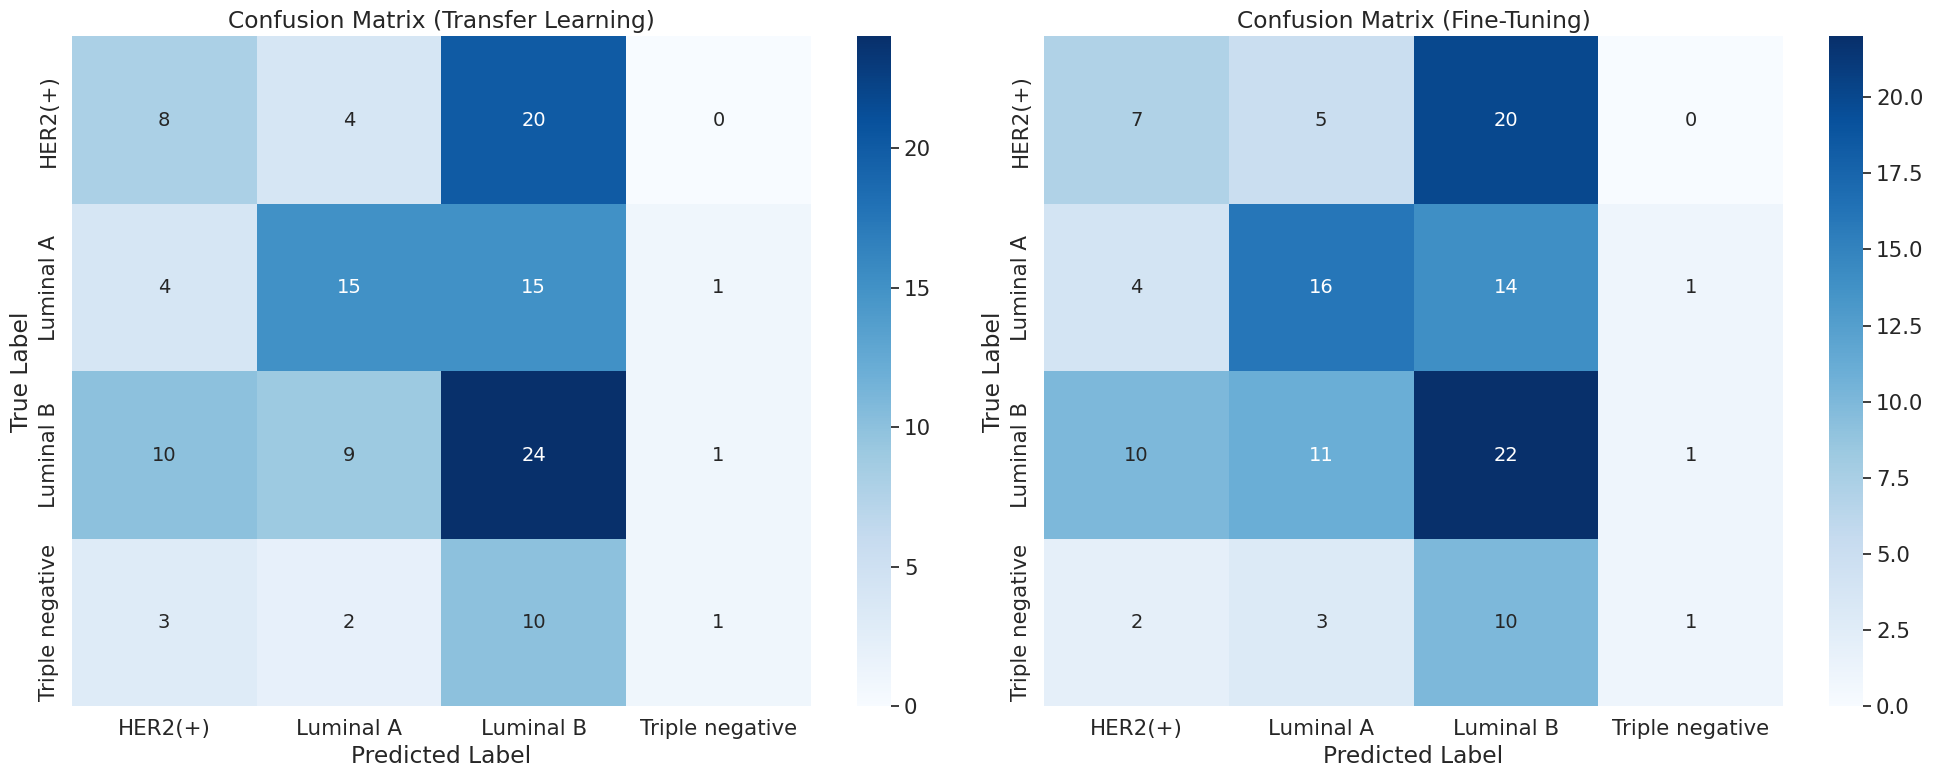

In [54]:

# 1. Get predictions for the Transfer Learning model (from original `model`)
print("Generating Confusion Matrix for Transfer Learning Model...")
y_true_tl, y_pred_tl = get_image_predictions(model, val_loader, device)
cm_tl = confusion_matrix(y_true_tl, y_pred_tl)

# 2. Get predictions for the Fine-Tuning model (from `ft_model`)
print("Generating Confusion Matrix for Fine-Tuning Model...")
y_true_ft, y_pred_ft = get_image_predictions(ft_model, val_loader, device)
cm_ft = confusion_matrix(y_true_ft, y_pred_ft)

# 3. Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot Transfer Learning Confusion Matrix
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix (Transfer Learning)')

# Plot Fine-Tuning Confusion Matrix
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix (Fine-Tuning)')

plt.tight_layout()
plt.show()


Transfer Learning:


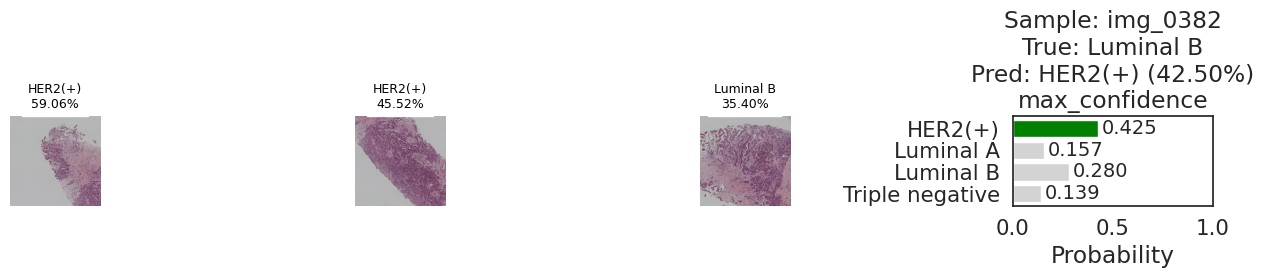

Fine Tuning:


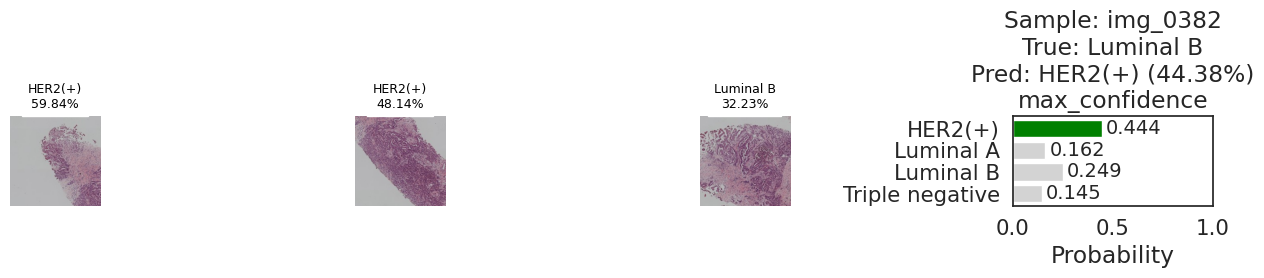

In [55]:
# Visualize a random validation sample
print("Transfer Learning:")
sample_id_plot = np.random.choice(val_loader.dataset.df['sample_id'].unique())
plot_sample_with_predictions(model, val_loader, device, label_encoder, aggregation_method='max_confidence', sample_id=sample_id_plot)
print("Fine Tuning:")
plot_sample_with_predictions(ft_model, val_loader, device, label_encoder, aggregation_method='max_confidence', sample_id=sample_id_plot)

## **14. Class Activation Maps**

### **14.1 Cam Helper Functions**

In [66]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchvision import transforms
from PIL import Image
import os

# --- 1. Grad-CAM Helper Class ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hooks
        self.handle_fwd = self.target_layer.register_forward_hook(self.save_activation)
        self.handle_bwd = self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # Forward pass
        # --- FIX: Unpack tuple (logits, mask_output) ---
        output, _ = self.model(x)
        
        if class_idx is None:
            class_idx = torch.argmax(output)
            
        # Backward pass
        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward()
        
        # Generate CAM
        gradients = self.gradients
        activations = self.activations
        b, k, u, v = gradients.size()
        
        # Global Average Pooling
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        
        # Linear combination
        cam = (weights * activations).sum(1, keepdim=True)
        cam = F.relu(cam) 
        
        # Normalize
        cam = cam.view(1, -1)
        cam -= cam.min()
        cam /= (cam.max() + 1e-7)
        cam = cam.view(1, 1, u, v)
        
        return cam.detach().cpu().numpy()[0, 0], output

    def remove_hooks(self):
        self.handle_fwd.remove()
        self.handle_bwd.remove()

# --- 2. Mask Overlay Function ---
def get_mask_overlay(cam_mask, patch_path, masks_dir, img_fallback=None, alpha=0.6):
    """
    Overlays a Class Activation Map (CAM) onto the ground truth mask.
    Returns: (overlay_image, mask_found_boolean)
    """
    bg_img = None
    mask_found = False

    if masks_dir:
        # Derive mask filename: img_xxxx.png -> mask_xxxx.png
        filename = os.path.basename(patch_path)
        mask_filename = filename.replace('img_', 'mask_')
        mask_path = os.path.join(masks_dir, mask_filename)

        if os.path.exists(mask_path):
            try:
                mask_pil = Image.open(mask_path).convert('L') 
                mask_pil = mask_pil.resize((224, 224))
                mask_np = np.array(mask_pil)
                # Normalize and convert to RGB
                mask_display = mask_np.astype(np.float32) / 255.0 
                bg_img = np.stack([mask_display]*3, axis=-1)
                mask_found = True
            except Exception as e:
                print(f"Error loading mask {mask_filename}: {e}")

    # Fallback Logic
    if bg_img is None:
        if img_fallback is not None:
            bg_img = img_fallback
        else:
            bg_img = np.zeros((224, 224, 3), dtype=np.float32)

    # Process Heatmap
    heatmap = cv2.resize(cam_mask, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = np.float32(heatmap_colored) / 255

    # Overlay
    overlay = (alpha * heatmap_colored) + ((1 - alpha) * bg_img)
    overlay = overlay / np.max(overlay) 
    
    return overlay, mask_found

# --- 3. Main Visualization Function ---
def visualize_sample_analysis(model, df_metadata, sample_id, label_encoder, device, masks_dir=None):
    """
    Visualizes analysis for a sample. 
    """
    model.eval()
    
    # Setup
    sample_rows = df_metadata[df_metadata['sample_id'] == sample_id]
    if len(sample_rows) == 0:
        print(f"Sample {sample_id} not found.")
        return

    # Define transforms locally to match training
    transform_pipeline = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    inv_normalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                             std=[1/0.229, 1/0.224, 1/0.225])
    ])

    # Inference
    patch_probs = []
    patch_images = []
    
    # Select target layer: The last layer of the features backbone
    target_layer = model.backbone.features[-1] 
    grad_cam = GradCAM(model, target_layer)
    
    print(f"Processing sample {sample_id}...")
    
    for _, row in sample_rows.iterrows():
        try:
            img_pil = Image.open(row['path']).convert('RGB')
            img_tensor = transform_pipeline(img_pil).unsqueeze(0).to(device)
            patch_images.append({'tensor': img_tensor, 'path': row['path']})
            
            with torch.no_grad():
                # --- FIX: Unpack tuple ---
                outputs, _ = model(img_tensor)
                probs = F.softmax(outputs, dim=1)
                patch_probs.append(probs.cpu().numpy())
        except Exception as e:
            print(f"Skipping bad image {row['path']}: {e}")
            continue

    if not patch_probs:
        print("No valid patches found.")
        grad_cam.remove_hooks()
        return

    patch_probs = np.vstack(patch_probs)
    avg_probs = np.mean(patch_probs, axis=0) 
    
    classes = label_encoder.classes_
    pred_class_idx = np.argmax(avg_probs)
    pred_label = classes[pred_class_idx]
    
    # Get true label from dataframe
    if 'label_encoded' in sample_rows.columns:
        true_label_idx = sample_rows.iloc[0]['label_encoded']
        true_label = label_encoder.inverse_transform([true_label_idx])[0]
    else:
        true_label = "Unknown"
    
    # Find Best Patch (Highest confidence for the predicted class)
    best_patch_idx = np.argmax(patch_probs[:, pred_class_idx])
    best_patch_data = patch_images[best_patch_idx]
    
    # Prepare tensor for GradCAM (requires gradient tracking)
    img_tensor_active = best_patch_data['tensor'].clone().detach()
    img_tensor_active.requires_grad = True # Force gradient computation
    patch_path = best_patch_data['path']

    # 1. Background Image (Denormalize for display)
    img_display = inv_normalize(best_patch_data['tensor'][0]).cpu().detach().numpy()
    img_display = np.transpose(img_display, (1, 2, 0))
    img_display = np.clip(img_display, 0, 1)

    # 2. Predicted Class CAMs
    # Note: grad_cam will handle the tuple unpacking internally now
    pred_cam_mask, _ = grad_cam(img_tensor_active, pred_class_idx)
    
    # A: Overlay on Image
    heatmap = cv2.resize(pred_cam_mask, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = np.float32(heatmap_colored) / 255
    cam_on_image = (0.5 * heatmap_colored) + (0.5 * img_display)
    cam_on_image = cam_on_image / np.max(cam_on_image)
    
    # B: Overlay on Mask (Row 1, Col 3)
    cam_on_mask_main, mask_found_main = get_mask_overlay(
        pred_cam_mask, patch_path, masks_dir, img_fallback=img_display
    )

    # 3. Other Classes CAMs (Row 2)
    cam_others_data = {}
    for i in range(len(classes)):
        if i == pred_class_idx: continue
        # Force gradient for other classes
        img_tensor_active.grad = None 
        mask, _ = grad_cam(img_tensor_active, i)
        
        overlay, is_mask = get_mask_overlay(
            mask, patch_path, masks_dir, img_fallback=img_display
        )
        cam_others_data[i] = (overlay, is_mask)
        
    grad_cam.remove_hooks() 

    # --- Plotting ---
    other_indices = [i for i in range(len(classes)) if i != pred_class_idx]
    
    fig = plt.figure(figsize=(24, 10))
    gs = gridspec.GridSpec(2, max(4, len(other_indices)), height_ratios=[1.2, 0.8])

    # Row 1
    # 1. Original
    ax0 = plt.subplot(gs[0, 0])
    ax0.imshow(img_display)
    ax0.set_title(f"Most Representative Patch\nTrue: {true_label}", fontsize=12, fontweight='bold')
    ax0.axis('off')

    # 2. Predicted CAM on Image
    ax1 = plt.subplot(gs[0, 1])
    ax1.imshow(cam_on_image)
    ax1.set_title(f"Focus on Image: {pred_label}\n(Score: {avg_probs[pred_class_idx]:.2f})", fontsize=12, fontweight='bold', color='darkblue')
    ax1.axis('off')
    
    # 3. Predicted CAM on Mask (Conditional)
    ax2 = plt.subplot(gs[0, 2])
    if mask_found_main:
        ax2.imshow(cam_on_mask_main)
        ax2.set_title(f"Focus on Mask: {pred_label}\n(Ground Truth Overlay)", fontsize=12, fontweight='bold')
        ax2.axis('off')
    else:
        ax2.set_visible(False)

    # 4. Stats
    ax3 = plt.subplot(gs[0, 3])
    colors = ['#d3d3d3'] * len(classes)
    colors[pred_class_idx] = '#4CAF50' if pred_label == true_label else '#F44336'
    
    bars = ax3.bar(classes, avg_probs, color=colors, alpha=0.85, edgecolor='black')
    ax3.set_title(f"Bag Prediction Probabilities\nSample ID: {sample_id}", fontsize=12, fontweight='bold')
    ax3.set_ylim(0, 1.05)
    ax3.grid(axis='y', linestyle='--', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Row 2: Other Classes on MASK (with fallback)
    for idx, class_idx in enumerate(other_indices):
        ax = plt.subplot(gs[1, idx])
        overlay, is_mask = cam_others_data[class_idx]
        
        ax.imshow(overlay)
        class_name = classes[class_idx]
        bg_type = "Mask" if is_mask else "Img"
        ax.set_title(f"Activ. on {bg_type}: {class_name}\n(Score: {avg_probs[class_idx]:.2f})", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### **14.2 CAM Visualization**

Processing sample img_0012...


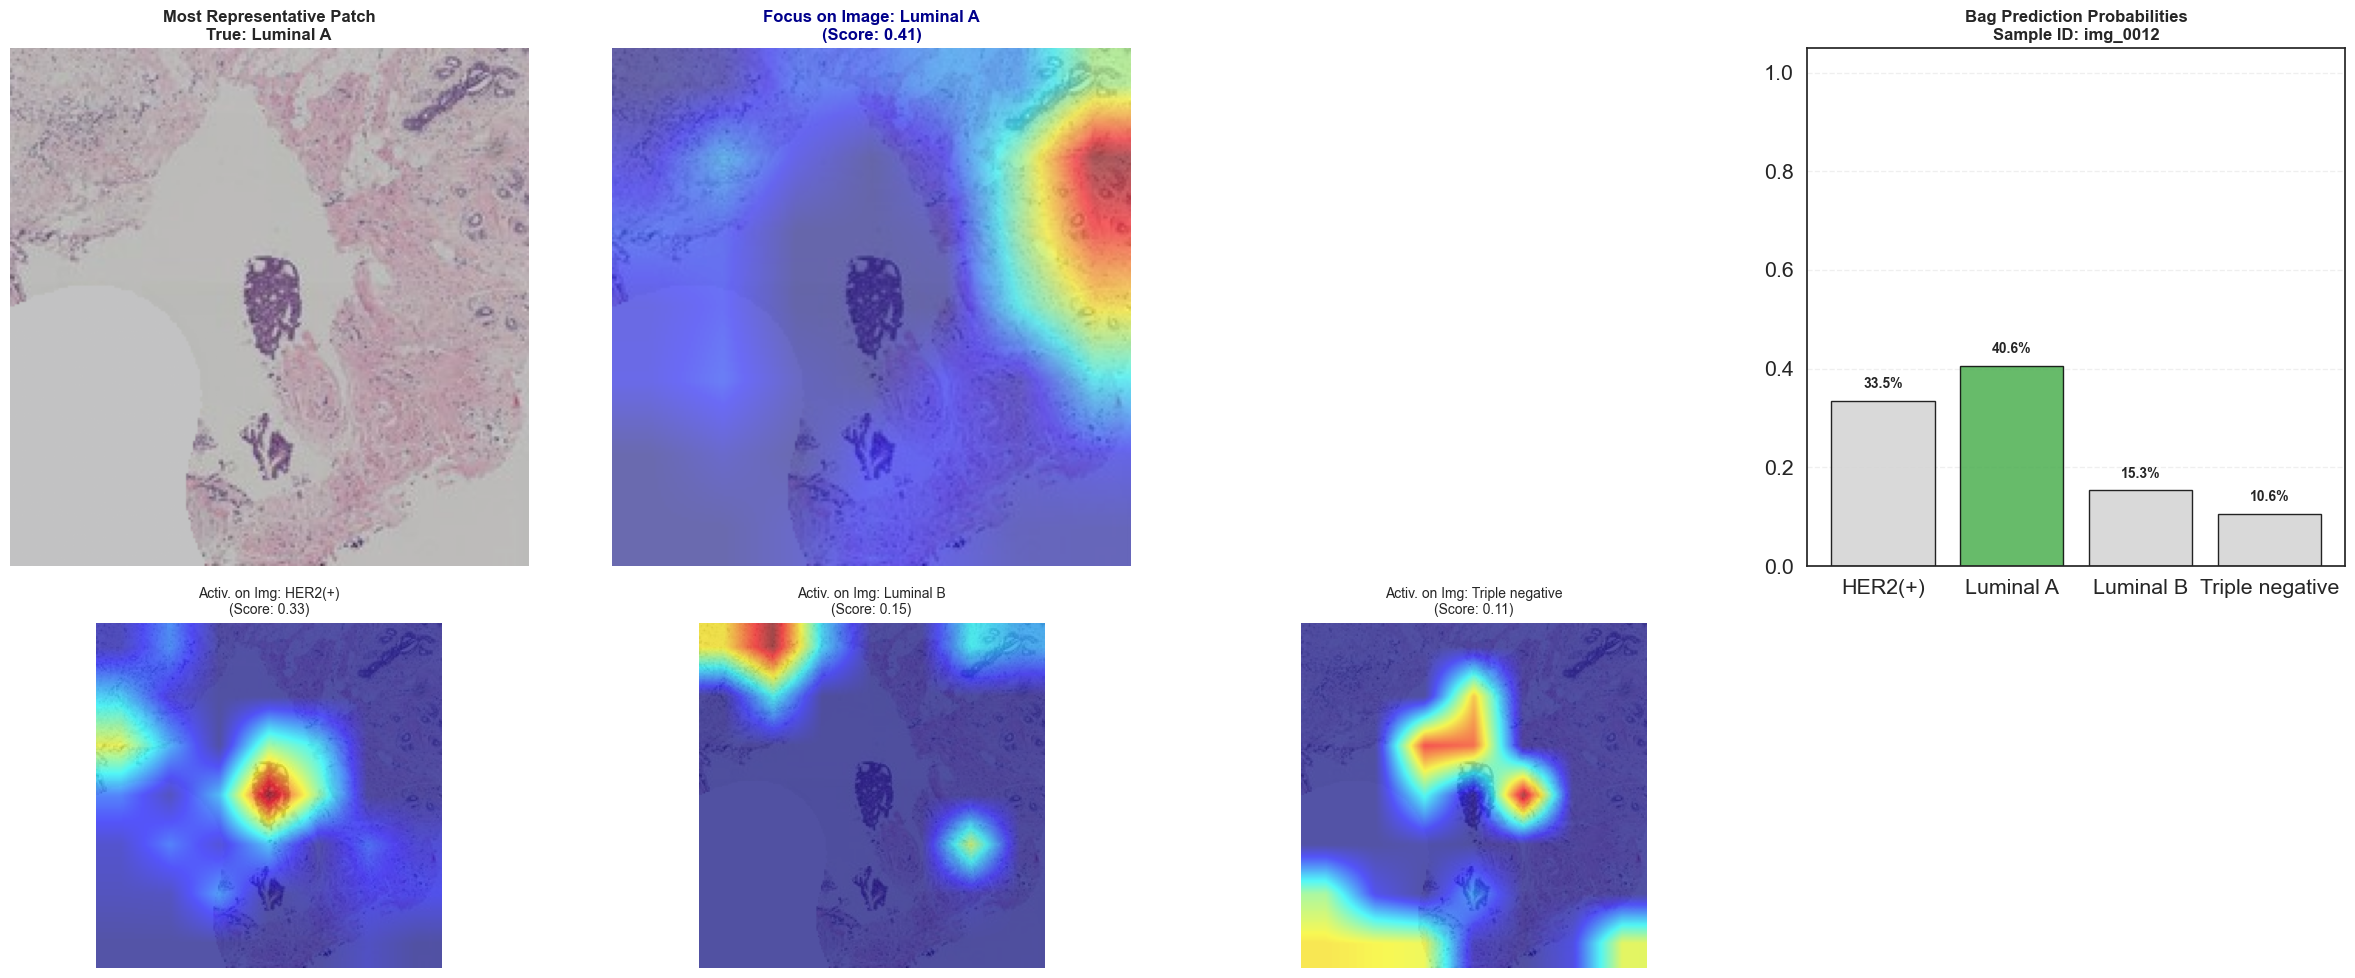

Processing sample img_0012...


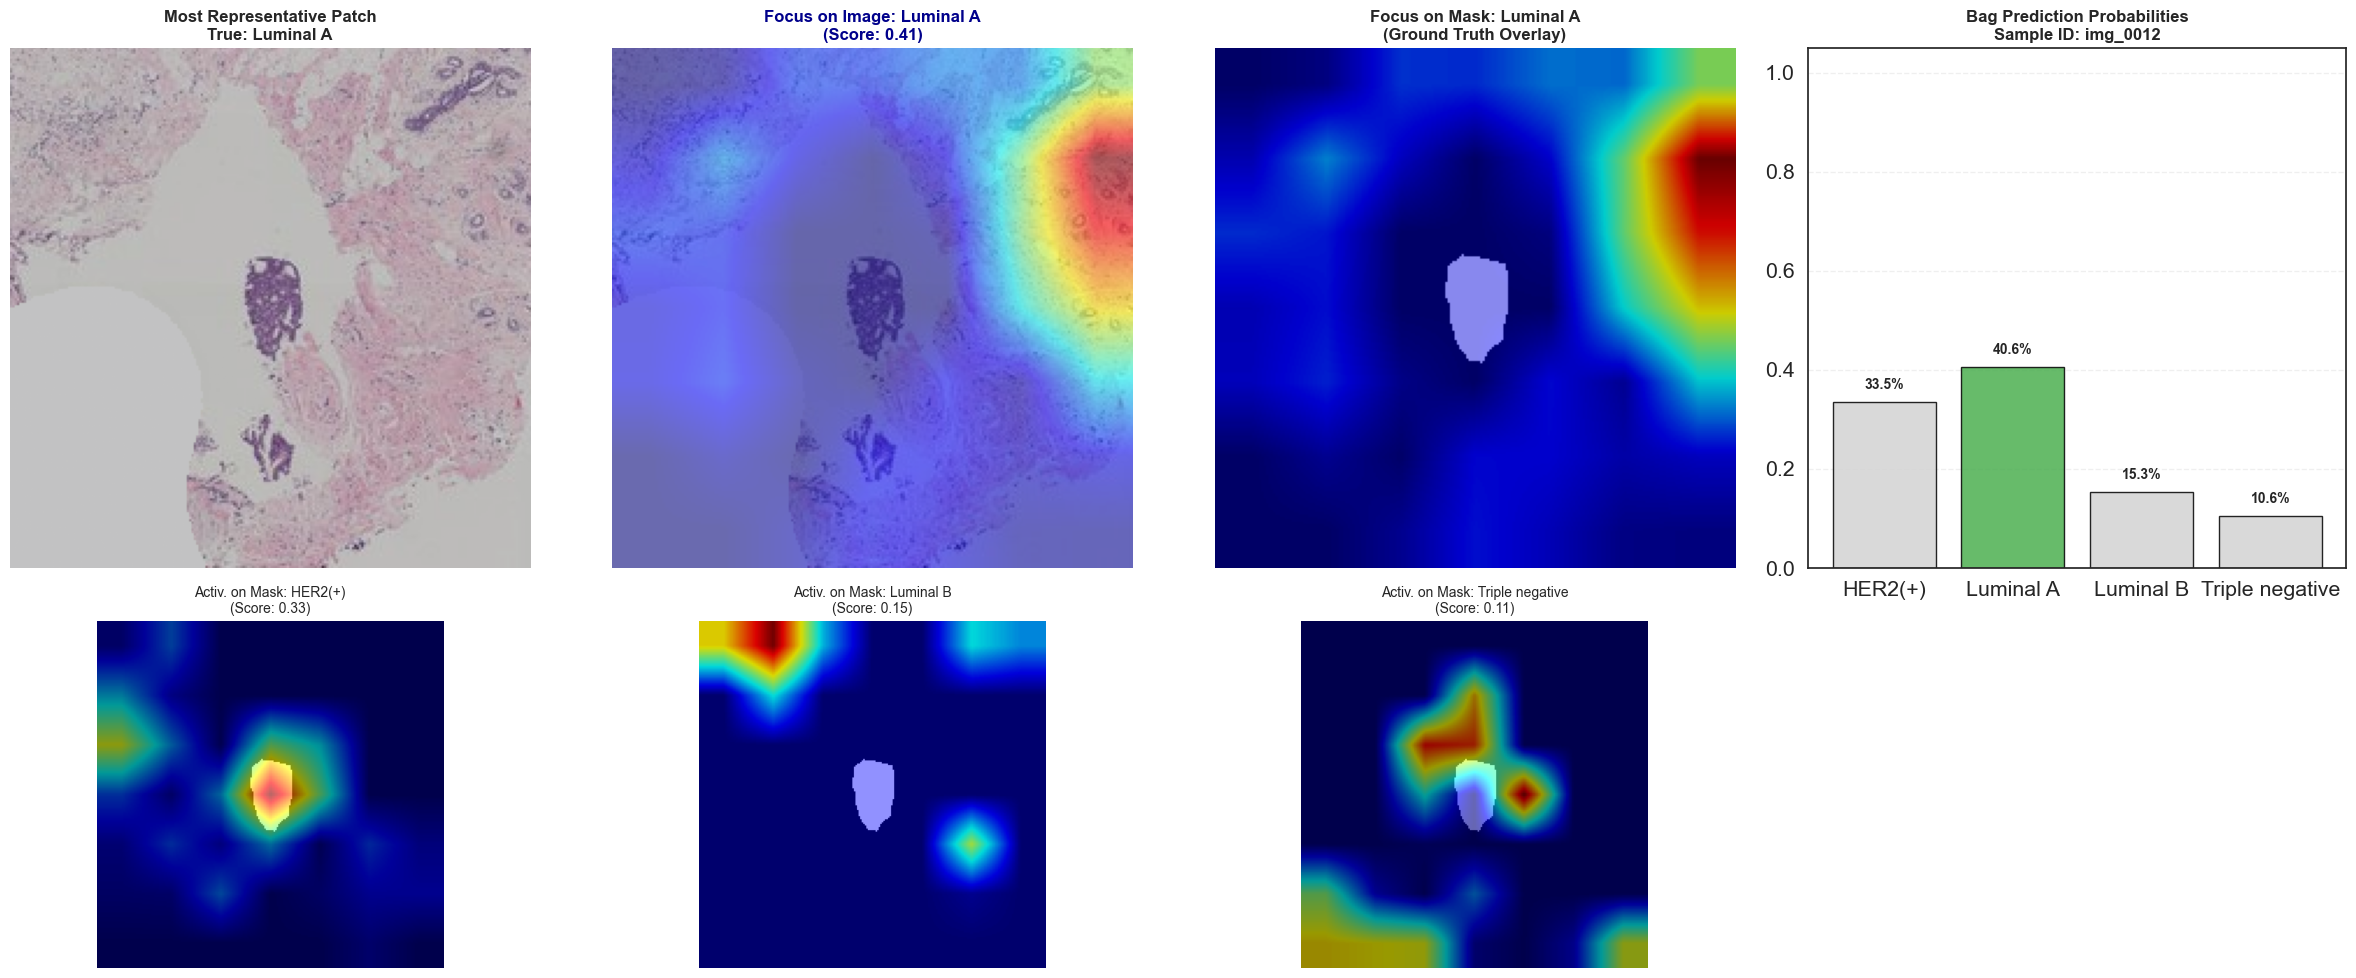

In [ ]:
# Select a sample ID from your validation set
if SUB_MODEL is None:
    SUB_MODEL = 'models/best_model_ResNetMTL_tl.pt'  # Default to TL model if none specified
PATCH_MASKS_DIR = os.path.join(datasets_path, "preprocessing_results","train_patches","masks")
cam_model = ResNetMTL(num_classes, DROPOUT_RATE, freeze_backbone=True).to(device)
cam_model.load_state_dict(torch.load(SUB_MODEL), strict=True)
cam_idx = random.randint(0, len(df_val['sample_id'].unique()) - 1)
sample_id_to_test = df_val['sample_id'].iloc[cam_idx] 
visualize_sample_analysis(cam_model, patches_metadata_df, sample_id_to_test, label_encoder, device)
visualize_sample_analysis(cam_model, patches_metadata_df, sample_id_to_test, label_encoder, device, masks_dir=PATCH_MASKS_DIR)

## **14. Submission Creation**

### 14.1 Create Submission Model

In [ ]:
sub_model = ResNetMTL(num_classes, DROPOUT_RATE, freeze_backbone=True).to(device)

# 2. Load the best weights from the training
sub_model.load_state_dict(torch.load(SUB_MODEL), strict=True)
print(f"Submodel loaded from {SUB_MODEL} for final evaluation.")


Submodel loaded from models/best_model_mobilenetv3Multi_tl.pt for final evaluation.


### 14.2 Define Transform

In [76]:
# Define Validation Transform (Compatible with V2 or Standard)
val_transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(), # Robust standard equivalent to ToImage + ToDtype
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


### 14.3 Function: Submission CSV

In [77]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import transforms

# --- Ensure Constants are Defined ---
# (Adjust these if your global variables are named differently)
TARGET_SIZE = (224, 224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


def generate_submission(model, submission_folder, method='max_confidence', output_csv="submission.csv"):
    """
    Generates a submission file by predicting on patches and aggregating results.
    """
    model.eval()

    # 1. Get list of test patches
    patch_files = sorted([f for f in os.listdir(submission_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    print(f"Found {len(patch_files)} patches in {submission_folder}")
    print(f"Aggregation Method: {method}")

    # Store predictions per image
    image_predictions = {}

    print("Running inference...")
    with torch.no_grad():
        for filename in tqdm(patch_files):
            filepath = os.path.join(submission_folder, filename)

            try:
                # Extract Sample ID
                # Example: "img_0015_p12.png" -> "img_0015"
                # Logic: Split at the LAST occurrence of '_p'
                if '_p' in filename:
                    sample_id = filename.rsplit('_p', 1)[0]
                else:
                    # Fallback if naming convention fails
                    sample_id = os.path.splitext(filename)[0]

                if sample_id not in image_predictions:
                    image_predictions[sample_id] = {'probs': []}

                # Load and Transform
                image = Image.open(filepath).convert('RGB')
                input_tensor = val_transform(image).unsqueeze(0).to(device)

                # --- CRITICAL FIX START ---
                # Unpack tuple: (class_logits, mask_logits)
                logits, _ = model(input_tensor) 
                # --- CRITICAL FIX END ---

                probs = torch.softmax(logits, dim=1)

                # Store probabilities
                image_predictions[sample_id]['probs'].append(probs.cpu().numpy()[0])

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # 3. Aggregate Results
    final_results = []

    print(f"Aggregating results for {len(image_predictions)} unique samples...")

    for sample_id, data in image_predictions.items():
        all_probs = np.array(data['probs']) # Shape: [Num_Patches, Num_Classes]

        # Ensure sample_index includes extension (e.g. img_0015.png)
        # Note: Check the competition rules. Usually, it's just ID or ID.png
        sample_index_name = f"{sample_id}.png"

        if len(all_probs) == 0:
            # Fallback
            final_results.append({'sample_index': sample_index_name, 'label': "Luminal A"}) 
            continue

        if method == 'majority_voting':
            patch_preds = np.argmax(all_probs, axis=1)
            counts = np.bincount(patch_preds)
            final_class_idx = np.argmax(counts)

        elif method == 'max_confidence':
            # Average probabilities (Soft Voting)
            avg_probs = np.mean(all_probs, axis=0)
            final_class_idx = np.argmax(avg_probs)

        # Decode Label
        pred_label = label_encoder.inverse_transform([final_class_idx])[0]
        final_results.append({'sample_index': sample_index_name, 'label': pred_label})

    # 4. Create DataFrame and Save
    df_submission = pd.DataFrame(final_results)
    
    # Sort and Save
    if 'sample_index' in df_submission.columns:
        df_submission.sort_values('sample_index', inplace=True)
    
    df_submission.to_csv(output_csv, index=False)

    print(f"Submission saved to {output_csv}")
    print(df_submission.head())

    return df_submission

### 14.3 Create the Submission CSV

In [78]:
# Example Usage:
# Replace 'path/to/SUBMISSION_PATCHES' with the actual path
# If your folder is just named SUBMISSION_PATCHES in current dir:


now = datetime.now()
date_time_str = now.strftime("%d_%b-%H_%M")

sub_dir = os.path.join(os.path.pardir, "submission_csvs")
OUTPUT_NAME = os.path.join(sub_dir, f"submission_ft--{date_time_str}.csv")


os.makedirs(sub_dir, exist_ok=True)

# Check if folder exists
if os.path.exists(SUBMISSION_PATCHES_OUT):
    # Method 1: Max Confidence / Average Probability (Recommended)
    df_sub_max_conf = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, method='max_confidence', output_csv=OUTPUT_NAME)
    print(f"Submission CSV saved to: {OUTPUT_NAME}")

    # Method 2: Majority Voting (Optional, uncomment to run)
    # df_sub_majority_voting = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, method='majority_voting', output_csv="submission_voting.csv")
else:
    print(f"Directory '{SUBMISSION_PATCHES_OUT}' not found. Please create it or set the correct path.")

Found 2160 patches in ..\an2dl2526c2\preprocessing_results\submission_patches
Aggregation Method: max_confidence
Running inference...


100%|██████████| 2160/2160 [00:42<00:00, 50.90it/s]



Aggregating results for 477 unique samples...
Submission saved to ..\submission_csvs\submission_ft--09_Dec-18_13.csv
   sample_index      label
0  img_0000.png  Luminal A
1  img_0001.png  Luminal B
2  img_0002.png  Luminal B
3  img_0003.png    HER2(+)
4  img_0004.png  Luminal B
Submission CSV saved to: ..\submission_csvs\submission_ft--09_Dec-18_13.csv
